# NnScript

Preprocessing done

Training with 50 hidden units and λ = 0


<ipython-input-7-564a8b8a3f00>:16: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Train Accuracy: 90.73%  |  Validation Accuracy: 89.39%  |  Test Accuracy: 89.77%

Training with 50 hidden units and λ = 0.01
Train Accuracy: 90.77%  |  Validation Accuracy: 89.71%  |  Test Accuracy: 90.28%

Training with 50 hidden units and λ = 0.1
Train Accuracy: 90.56%  |  Validation Accuracy: 89.63%  |  Test Accuracy: 90.23%

Training with 50 hidden units and λ = 1
Train Accuracy: 90.06%  |  Validation Accuracy: 89.40%  |  Test Accuracy: 89.91%

Training with 100 hidden units and λ = 0
Train Accuracy: 92.69%  |  Validation Accuracy: 91.27%  |  Test Accuracy: 91.89%

Training with 100 hidden units and λ = 0.01
Train Accuracy: 92.80%  |  Validation Accuracy: 91.56%  |  Test Accuracy: 92.30%

Training with 100 hidden units and λ = 0.1
Train Accuracy: 93.08%  |  Validation Accuracy: 91.80%  |  Test Accuracy: 92.22%

Training with 100 hidden units and λ = 1
Train Accuracy: 93.14%  |  Validation Accuracy: 91.46%  |  Test Accuracy: 92.35%

Training with 150 hidden units and λ = 0
Train Acc

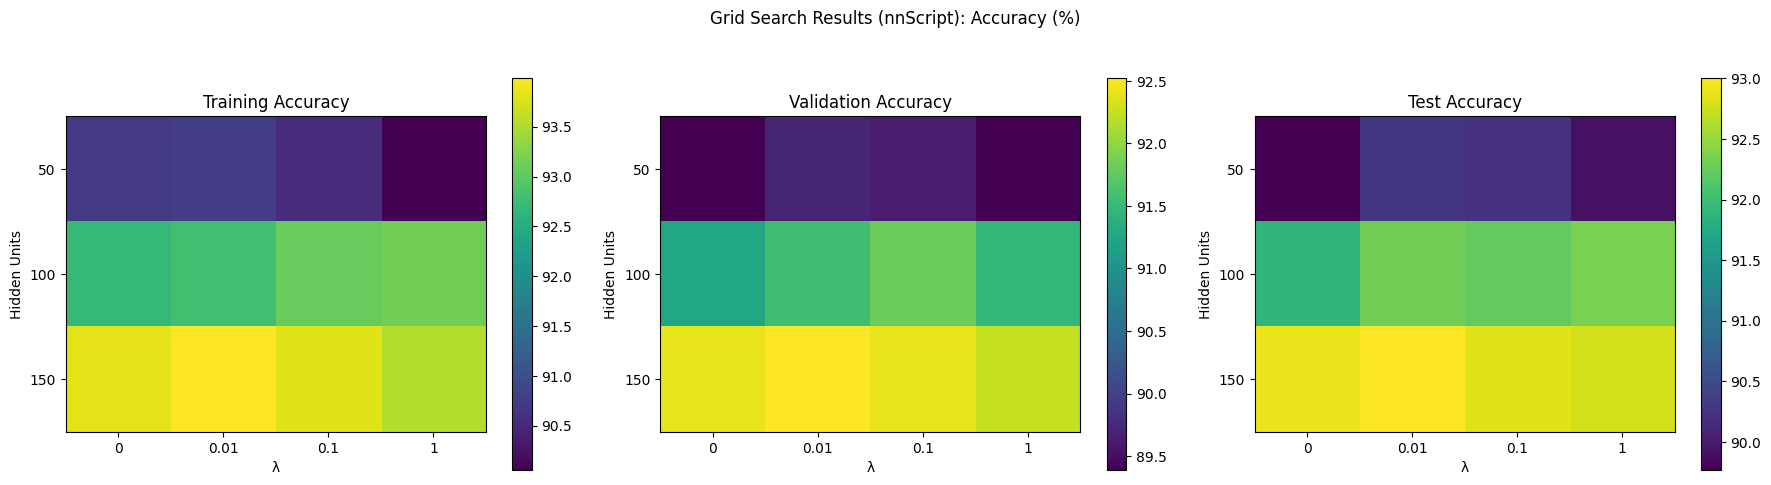

In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt

def initializeWeights(n_in, n_out):
    """
    Initialize weights for Neural Network.
    """
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W

def sigmoid(z):
    """Compute sigmoid function for scalar, vector or matrix input."""
    return 1.0 / (1.0 + np.exp(-z))

def preprocess():
    """Preprocess the MNIST data set.

    Loads 'mnist_all.mat', merges the digit-specific matrices into one training matrix,
    randomly splits off 10,000 examples for validation, and performs a simple feature selection.
    """
    mat = loadmat('mnist_all.mat')

    # Combine training data for all digits
    train_data_list = []
    train_label_list = []
    for digit in range(10):
        key = 'train' + str(digit)
        data = mat[key]
        labels = np.full((data.shape[0],), digit)
        train_data_list.append(data)
        train_label_list.append(labels)
    all_train_data = np.vstack(train_data_list)
    all_train_labels = np.hstack(train_label_list)

    # Shuffle training data
    perm = np.random.permutation(all_train_data.shape[0])
    all_train_data = all_train_data[perm, :]
    all_train_labels = all_train_labels[perm]

    # Split training into train (50000) and validation (10000)
    train_data = all_train_data[:50000, :].astype(float)
    train_label = all_train_labels[:50000]
    validation_data = all_train_data[50000:, :].astype(float)
    validation_label = all_train_labels[50000:]

    # Process test data (combine from each digit)
    test_data_list = []
    test_label_list = []
    for digit in range(10):
        key = 'test' + str(digit)
        data = mat[key]
        labels = np.full((data.shape[0],), digit)
        test_data_list.append(data)
        test_label_list.append(labels)
    test_data = np.vstack(test_data_list).astype(float)
    test_label = np.hstack(test_label_list)

    # Example feature selection: remove features with zero variance
    variances = np.var(train_data, axis=0)
    selected_features = variances > 0
    train_data = train_data[:, selected_features]
    validation_data = validation_data[:, selected_features]
    test_data = test_data[:, selected_features]

    print('Preprocessing done')
    return train_data, train_label, validation_data, validation_label, test_data, test_label

def nnObjFunction(params, *args):
    """
    Computes the value of objective function (negative log likelihood with regularization)
    and its gradient for a neural network.
    """
    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    # Reshape 'params' into w1 and w2 weight matrices
    w1 = params[0: n_hidden * (n_input + 1)].reshape((n_hidden, n_input + 1))
    w2 = params[n_hidden * (n_input + 1):].reshape((n_class, n_hidden + 1))

    m = training_data.shape[0]

    # Add bias to training data
    bias = np.ones((m, 1))
    training_data_bias = np.hstack((training_data, bias))

    # Forward propagation
    z2 = training_data_bias.dot(w1.T)
    a2 = sigmoid(z2)
    a2_bias = np.hstack((a2, np.ones((a2.shape[0], 1))))
    z3 = a2_bias.dot(w2.T)
    a3 = sigmoid(z3)  # final output

    # One-hot encode labels
    y = np.zeros((m, n_class))
    for i in range(m):
        y[i, int(training_label[i])] = 1

    # Compute error using negative log likelihood
    log_loss = -y * np.log(a3) - (1 - y) * np.log(1 - a3)
    error = np.sum(log_loss) / m

    # Regularization term (exclude bias weights)
    reg_term = (lambdaval / (2 * m)) * (np.sum(np.square(w1[:, :-1])) + np.sum(np.square(w2[:, :-1])))
    obj_val = error + reg_term

    # Backpropagation
    delta3 = a3 - y
    grad_w2 = (delta3.T).dot(a2_bias) / m
    # Remove bias weight from w2 before computing delta2
    delta2 = delta3.dot(w2[:, :-1]) * a2 * (1 - a2)
    grad_w1 = (delta2.T).dot(training_data_bias) / m

    # Add regularization to gradients (do not regularize bias term)
    grad_w1[:, :-1] += (lambdaval / m) * w1[:, :-1]
    grad_w2[:, :-1] += (lambdaval / m) * w2[:, :-1]

    # Flatten gradients
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()))

    return (obj_val, obj_grad)

def nnPredict(w1, w2, data):
    """Predict the label of data given the weights of the network."""
    m = data.shape[0]
    bias = np.ones((m, 1))
    data_bias = np.hstack((data, bias))
    z2 = data_bias.dot(w1.T)
    a2 = sigmoid(z2)
    a2_bias = np.hstack((a2, np.ones((a2.shape[0], 1))))
    z3 = a2_bias.dot(w2.T)
    a3 = sigmoid(z3)
    labels = np.argmax(a3, axis=1)
    return labels

import pickle
import matplotlib.pyplot as plt

"""************** Neural Network Script Starts Here ************************"""
if __name__ == "__main__":
    # Preprocess data.
    train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()
    n_input = train_data.shape[1]
    n_class = 10

    # For demonstration, assume all features are selected.
    selected_features = list(range(n_input))

    # Define grid for hyper-parameters.
    hidden_layer_sizes = [50, 100, 150]          # Example hidden layer sizes.
    lambdaval_list = [0, 0.01, 0.1, 1]      # Example λ values.

    # Dictionaries to store accuracies.
    grid_train = {}
    grid_val = {}
    grid_test = {}

    best_val_acc = 0
    best_params = None

    for n_hidden in hidden_layer_sizes:
        for lambdaval in lambdaval_list:
            print(f"\nTraining with {n_hidden} hidden units and λ = {lambdaval}")
            # Initialize weights.
            initial_w1 = initializeWeights(n_input, n_hidden)
            initial_w2 = initializeWeights(n_hidden, n_class)
            initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
            args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
            opts = {'maxiter': 50}

            # Train using Conjugate Gradient minimization.
            nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
            w1 = nn_params.x[0: n_hidden * (n_input + 1)].reshape((n_hidden, n_input + 1))
            # --- Updated line: reshape w2 to (n_class, n_hidden+1) ---
            w2 = nn_params.x[n_hidden * (n_input + 1):].reshape((n_class, n_hidden + 1))

            # Compute predictions.
            pred_train = nnPredict(w1, w2, train_data)
            pred_val = nnPredict(w1, w2, validation_data)
            pred_test = nnPredict(w1, w2, test_data)

            train_acc = 100 * np.mean((pred_train == train_label).astype(float))
            val_acc = 100 * np.mean((pred_val == validation_label).astype(float))
            test_acc = 100 * np.mean((pred_test == test_label).astype(float))
            print(f"Train Accuracy: {train_acc:.2f}%  |  Validation Accuracy: {val_acc:.2f}%  |  Test Accuracy: {test_acc:.2f}%")

            grid_train[(n_hidden, lambdaval)] = train_acc
            grid_val[(n_hidden, lambdaval)] = val_acc
            grid_test[(n_hidden, lambdaval)] = test_acc

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = (n_hidden, lambdaval, w1, w2)

    print("\n***** Grid Search Results (nnScript) *****")
    print(f"Best combination: Hidden Units = {best_params[0]}, λ = {best_params[1]}, Validation Accuracy = {best_val_acc:.2f}%")

    best_n_hidden, best_lambda, best_w1, best_w2 = best_params
    final_pred_test = nnPredict(best_w1, best_w2, test_data)
    final_test_acc = 100 * np.mean((final_pred_test == test_label).astype(float))
    print(f"Test Set Accuracy for best combination: {final_test_acc:.2f}%")

    # Save learned parameters.
    params_to_save = {
        'selected_features': selected_features,
        'optimal_n_hidden': best_n_hidden,
        'w1': best_w1,
        'w2': best_w2,
        'optimal_lambda': best_lambda
    }
    with open('nn_params.pickle', 'wb') as f:
        pickle.dump(params_to_save, f)
    print("Parameters saved to nn_params.pickle")

    # Create heatmaps for training, validation, and test accuracies.
    num_h = len(hidden_layer_sizes)
    num_l = len(lambdaval_list)
    heat_train = np.zeros((num_h, num_l))
    heat_val = np.zeros((num_h, num_l))
    heat_test = np.zeros((num_h, num_l))

    for i, h in enumerate(hidden_layer_sizes):
        for j, lam in enumerate(lambdaval_list):
            heat_train[i, j] = grid_train[(h, lam)]
            heat_val[i, j] = grid_val[(h, lam)]
            heat_test[i, j] = grid_test[(h, lam)]

    # Plot all three heatmaps in subplots.
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    im0 = axs[0].imshow(heat_train, interpolation='nearest', cmap='viridis')
    axs[0].set_title("Training Accuracy")
    axs[0].set_xticks(np.arange(num_l))
    axs[0].set_xticklabels(lambdaval_list)
    axs[0].set_yticks(np.arange(num_h))
    axs[0].set_yticklabels(hidden_layer_sizes)
    axs[0].set_xlabel("λ")
    axs[0].set_ylabel("Hidden Units")
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(heat_val, interpolation='nearest', cmap='viridis')
    axs[1].set_title("Validation Accuracy")
    axs[1].set_xticks(np.arange(num_l))
    axs[1].set_xticklabels(lambdaval_list)
    axs[1].set_yticks(np.arange(num_h))
    axs[1].set_yticklabels(hidden_layer_sizes)
    axs[1].set_xlabel("λ")
    axs[1].set_ylabel("Hidden Units")
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(heat_test, interpolation='nearest', cmap='viridis')
    axs[2].set_title("Test Accuracy")
    axs[2].set_xticks(np.arange(num_l))
    axs[2].set_xticklabels(lambdaval_list)
    axs[2].set_yticks(np.arange(num_h))
    axs[2].set_yticklabels(hidden_layer_sizes)
    axs[2].set_xlabel("λ")
    axs[2].set_ylabel("Hidden Units")
    fig.colorbar(im2, ax=axs[2])

    plt.suptitle("Grid Search Results (nnScript): Accuracy (%)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# FacennScript


Training with 128 hidden units and λ = 0
Train Accuracy: 84.95%  |  Validation Accuracy: 83.45%  |  Test Accuracy: 84.67%

Training with 128 hidden units and λ = 0.001
Train Accuracy: 84.55%  |  Validation Accuracy: 83.30%  |  Test Accuracy: 85.12%

Training with 128 hidden units and λ = 0.01
Train Accuracy: 86.26%  |  Validation Accuracy: 84.99%  |  Test Accuracy: 86.11%

Training with 128 hidden units and λ = 0.1
Train Accuracy: 85.77%  |  Validation Accuracy: 84.77%  |  Test Accuracy: 86.07%

Training with 128 hidden units and λ = 10
Train Accuracy: 84.52%  |  Validation Accuracy: 83.08%  |  Test Accuracy: 84.67%

Training with 256 hidden units and λ = 0
Train Accuracy: 85.64%  |  Validation Accuracy: 84.92%  |  Test Accuracy: 85.39%

Training with 256 hidden units and λ = 0.001
Train Accuracy: 85.52%  |  Validation Accuracy: 84.65%  |  Test Accuracy: 85.81%

Training with 256 hidden units and λ = 0.01
Train Accuracy: 84.62%  |  Validation Accuracy: 83.08%  |  Test Accuracy: 85.16%

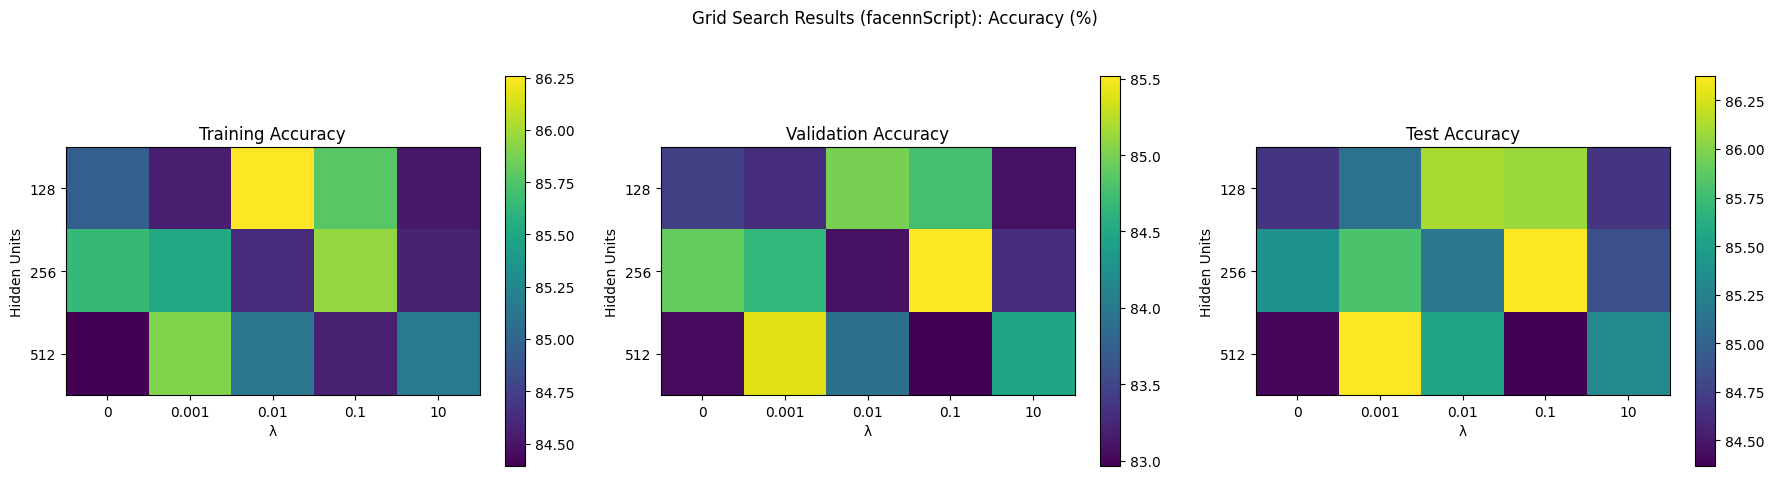

In [2]:
"""
Comparing single layer MLP with deep MLP (using TensorFlow)
"""

import numpy as np
import pickle
from scipy.optimize import minimize
from math import sqrt
import matplotlib.pyplot as plt

def initializeWeights(n_in, n_out):
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def nnObjFunction(params, *args):
    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0: n_hidden * (n_input + 1)].reshape((n_hidden, n_input + 1))
    w2 = params[n_hidden * (n_input + 1):].reshape((n_class, n_hidden + 1))

    m = training_data.shape[0]
    bias = np.ones((m, 1))
    training_data_bias = np.hstack((training_data, bias))

    z2 = training_data_bias.dot(w1.T)
    a2 = sigmoid(z2)
    a2_bias = np.hstack((a2, np.ones((a2.shape[0], 1))))
    z3 = a2_bias.dot(w2.T)
    a3 = sigmoid(z3)

    y = np.zeros((m, n_class))
    for i in range(m):
        y[i, int(training_label[i])] = 1

    log_loss = -y * np.log(a3) - (1 - y) * np.log(1 - a3)
    error = np.sum(log_loss) / m
    reg_term = (lambdaval / (2 * m)) * (np.sum(np.square(w1[:, :-1])) + np.sum(np.square(w2[:, :-1])))
    obj_val = error + reg_term

    delta3 = a3 - y
    grad_w2 = (delta3.T).dot(a2_bias) / m
    delta2 = delta3.dot(w2[:, :-1]) * a2 * (1 - a2)
    grad_w1 = (delta2.T).dot(training_data_bias) / m

    grad_w1[:, :-1] += (lambdaval / m) * w1[:, :-1]
    grad_w2[:, :-1] += (lambdaval / m) * w2[:, :-1]

    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()))
    return (obj_val, obj_grad)

def nnPredict(w1, w2, data):
    m = data.shape[0]
    bias = np.ones((m, 1))
    data_bias = np.hstack((data, bias))
    z2 = data_bias.dot(w1.T)
    a2 = sigmoid(z2)
    a2_bias = np.hstack((a2, np.ones((a2.shape[0], 1))))
    z3 = a2_bias.dot(w2.T)
    a3 = sigmoid(z3)
    labels = np.argmax(a3, axis=1)
    return labels

def preprocess():
    pickle_obj = pickle.load(file=open('face_all.pickle', 'rb'))
    features = pickle_obj['Features']
    labels = pickle_obj['Labels']
    train_x = features[0:21100] / 255
    valid_x = features[21100:23765] / 255
    test_x = features[23765:] / 255

    labels = labels[0]
    train_y = labels[0:21100]
    valid_y = labels[21100:23765]
    test_y = labels[23765:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

"""************** Neural Network Script Starts here ********************************"""
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()
n_input = train_data.shape[1]
n_class = 2

# For demonstration, assume all features are selected.
selected_features = list(range(n_input))

# Define grid for hyper-parameters.
hidden_layer_sizes = [128, 256, 512]           # Example hidden layer sizes.
lambdaval_list = [0, 0.001, 0.01, 0.1, 10]       # Example λ values.

grid_train = {}
grid_val = {}
grid_test = {}

best_val_acc = 0
best_params = None

for n_hidden in hidden_layer_sizes:
    for lambdaval in lambdaval_list:
        print(f"\nTraining with {n_hidden} hidden units and λ = {lambdaval}")
        initial_w1 = initializeWeights(n_input, n_hidden)
        initial_w2 = initializeWeights(n_hidden, n_class)
        initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
        args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
        opts = {'maxiter': 50}

        nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
        params_opt = nn_params.get('x')
        w1 = params_opt[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
        # Updated reshape to match nnObjFunction
        w2 = params_opt[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

        pred_train = nnPredict(w1, w2, train_data)
        pred_val = nnPredict(w1, w2, validation_data)
        pred_test = nnPredict(w1, w2, test_data)

        train_acc = 100 * np.mean((pred_train == train_label).astype(float))
        val_acc = 100 * np.mean((pred_val == validation_label).astype(float))
        test_acc = 100 * np.mean((pred_test == test_label).astype(float))
        print(f"Train Accuracy: {train_acc:.2f}%  |  Validation Accuracy: {val_acc:.2f}%  |  Test Accuracy: {test_acc:.2f}%")

        grid_train[(n_hidden, lambdaval)] = train_acc
        grid_val[(n_hidden, lambdaval)] = val_acc
        grid_test[(n_hidden, lambdaval)] = test_acc

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = (n_hidden, lambdaval, w1, w2)

print("\n***** Grid Search Results for Face Classification *****")
print(f"Best combination: Hidden Units = {best_params[0]}, λ = {best_params[1]}, Validation Accuracy = {best_val_acc:.2f}%")

best_n_hidden, best_lambda, best_w1, best_w2 = best_params
final_pred_test = nnPredict(best_w1, best_w2, test_data)
final_test_acc = 100 * np.mean((final_pred_test == test_label).astype(float))
print(f"Test Set Accuracy for best combination: {final_test_acc:.2f}%")

# Save the learned parameters.
params_to_save = {
    'selected_features': selected_features,
    'optimal_n_hidden': best_n_hidden,
    'w1': best_w1,
    'w2': best_w2,
    'optimal_lambda': best_lambda
}
with open('face_params.pickle', 'wb') as f:
    pickle.dump(params_to_save, f)
print("Parameters saved to params.pickle")

# Create heatmaps.
num_h = len(hidden_layer_sizes)
num_l = len(lambdaval_list)
heat_train = np.zeros((num_h, num_l))
heat_val = np.zeros((num_h, num_l))
heat_test = np.zeros((num_h, num_l))

for i, h in enumerate(hidden_layer_sizes):
    for j, lam in enumerate(lambdaval_list):
        heat_train[i, j] = grid_train[(h, lam)]
        heat_val[i, j] = grid_val[(h, lam)]
        heat_test[i, j] = grid_test[(h, lam)]

# Plotting the results.
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

im0 = axs[0].imshow(heat_train, interpolation='nearest', cmap='viridis')
axs[0].set_title("Training Accuracy")
axs[0].set_xticks(np.arange(num_l))
axs[0].set_xticklabels(lambdaval_list)
axs[0].set_yticks(np.arange(num_h))
axs[0].set_yticklabels(hidden_layer_sizes)
axs[0].set_xlabel("λ")
axs[0].set_ylabel("Hidden Units")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(heat_val, interpolation='nearest', cmap='viridis')
axs[1].set_title("Validation Accuracy")
axs[1].set_xticks(np.arange(num_l))
axs[1].set_xticklabels(lambdaval_list)
axs[1].set_yticks(np.arange(num_h))
axs[1].set_yticklabels(hidden_layer_sizes)
axs[1].set_xlabel("λ")
axs[1].set_ylabel("Hidden Units")
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(heat_test, interpolation='nearest', cmap='viridis')
axs[2].set_title("Test Accuracy")
axs[2].set_xticks(np.arange(num_l))
axs[2].set_xticklabels(lambdaval_list)
axs[2].set_yticks(np.arange(num_h))
axs[2].set_yticklabels(hidden_layer_sizes)
axs[2].set_xlabel("λ")
axs[2].set_ylabel("Hidden Units")
fig.colorbar(im2, ax=axs[2])

plt.suptitle("Grid Search Results (facennScript): Accuracy (%)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# DeepnnScript

Using cpu device

Training deep MLP with 3 hidden layers.
Epoch 1/50
loss: 0.693858  [    0/21100]
loss: 0.690591  [ 6400/21100]
loss: 0.683986  [12800/21100]
loss: 0.678950  [19200/21100]
Epoch 2/50
loss: 0.671293  [    0/21100]
loss: 0.629296  [ 6400/21100]
loss: 0.613717  [12800/21100]
loss: 0.583599  [19200/21100]
Epoch 3/50
loss: 0.574710  [    0/21100]
loss: 0.483145  [ 6400/21100]
loss: 0.480706  [12800/21100]
loss: 0.472436  [19200/21100]
Epoch 4/50
loss: 0.471877  [    0/21100]
loss: 0.388532  [ 6400/21100]
loss: 0.504501  [12800/21100]
loss: 0.466005  [19200/21100]
Epoch 5/50
loss: 0.682741  [    0/21100]
loss: 0.412937  [ 6400/21100]
loss: 0.411051  [12800/21100]
loss: 0.459737  [19200/21100]
Epoch 6/50
loss: 0.447084  [    0/21100]
loss: 0.355437  [ 6400/21100]
loss: 0.417648  [12800/21100]
loss: 0.373112  [19200/21100]
Epoch 7/50
loss: 0.465612  [    0/21100]
loss: 0.346434  [ 6400/21100]
loss: 0.468808  [12800/21100]
loss: 0.408098  [19200/21100]
Epoch 8/50
loss: 0.449483

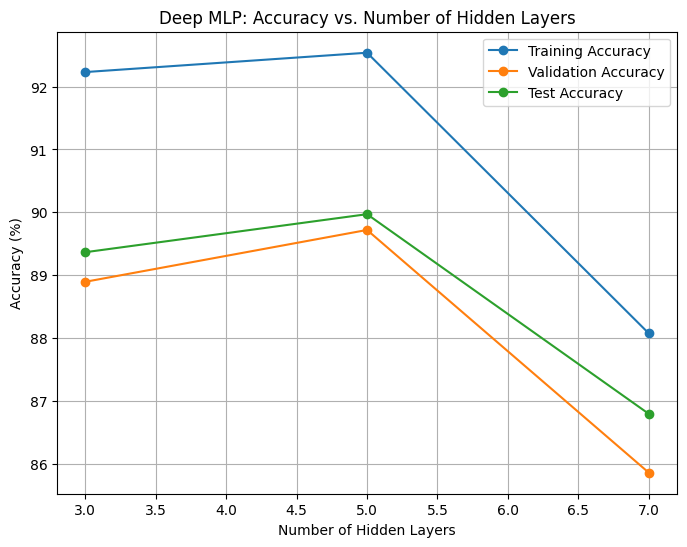

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Create a deep multilayer perceptron with a variable number of hidden layers.
def create_multilayer_perceptron(hidden_layers=[256, 256]):
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            n_input = 2376  # input feature dimension
            n_classes = 2   # number of classes

            # Build a list of layers.
            layers = []
            prev_dim = n_input
            for h in hidden_layers:
                layers.append(nn.Linear(prev_dim, h))
                layers.append(nn.ReLU())
                prev_dim = h
            # Final output layer.
            layers.append(nn.Linear(prev_dim, n_classes))
            self.net = nn.Sequential(*layers)

        def forward(self, x):
            return self.net(x)
    return Net()

def preprocess():
    pickle_obj = pickle.load(file=open('face_all.pickle', 'rb'))
    features = pickle_obj['Features']
    labels = pickle_obj['Labels']
    train_x = features[0:21100] / 255
    valid_x = features[21100:23765] / 255
    test_x = features[23765:] / 255

    labels = np.squeeze(labels)
    train_y = labels[0:21100]
    valid_y = labels[21100:23765]
    test_y = labels[23765:]

    class CustomDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    trainset = CustomDataset(train_x, train_y)
    validset = CustomDataset(valid_x, valid_y)
    testset = CustomDataset(test_x, test_y)

    return trainset, validset, testset

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X.float())
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss_val, current = loss.item(), batch * len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

def evaluate(dataloader, model):
    # Simple function to compute accuracy (in percentage) for a given dataloader.
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            correct += (pred.argmax(1) == y).sum().item()
    return 100 * correct / size

# Parameters
learning_rate = 0.01
training_epochs = 50
batch_size = 64

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load data.
trainset, validset, testset = preprocess()
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# List of different hidden layer depths to experiment with.
hidden_layer_options = [3, 5, 7]

# Containers to record accuracies.
train_accs = []
val_accs = []
test_accs = []

for num_layers in hidden_layer_options:
    print(f"\nTraining deep MLP with {num_layers} hidden layers.")
    # Create a list with 'num_layers' hidden layers, each of size 256.
    hidden_layers = [256] * num_layers
    model = create_multilayer_perceptron(hidden_layers).to(device)
    cost = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop.
    for epoch in range(training_epochs):
        print(f"Epoch {epoch+1}/{training_epochs}")
        train(train_dataloader, model, cost, optimizer)

    # Evaluate performance on train, validation, and test sets.
    train_acc = evaluate(train_dataloader, model)
    val_acc = evaluate(valid_dataloader, model)
    test_acc = evaluate(test_dataloader, model)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"Results for {num_layers} hidden layers:")
    print(f"Training Accuracy: {train_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%\n")

# Plot accuracies vs. number of hidden layers.
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(hidden_layer_options, train_accs, marker='o', label='Training Accuracy')
plt.plot(hidden_layer_options, val_accs, marker='o', label='Validation Accuracy')
plt.plot(hidden_layer_options, test_accs, marker='o', label='Test Accuracy')
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Accuracy (%)")
plt.title("Deep MLP: Accuracy vs. Number of Hidden Layers")
plt.legend()
plt.grid(True)
plt.show()


# CnnScript

Using cpu device
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 139MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 39.4MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 97.9MB/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.58MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Training CNN for 1 epochs
Epoch 1/1
loss: 2.315417  [    0/54000]
loss: 1.279522  [ 6400/54000]
loss: 0.492601  [12800/54000]
loss: 0.679276  [19200/54000]
loss: 0.393839  [25600/54000]
loss: 0.306362  [32000/54000]
loss: 0.265596  [38400/54000]
loss: 0.589750  [44800/54000]
loss: 0.258519  [51200/54000]
After 1 epochs: Train Acc = 92.58%, Val Acc = 92.43%, Test Acc = 92.98%

Training CNN for 5 epochs
Epoch 1/5
loss: 2.298823  [    0/54000]
loss: 1.376262  [ 6400/54000]
loss: 0.549202  [12800/54000]
loss: 0.424238  [19200/54000]
loss: 0.327421  [25600/54000]
loss: 0.304337  [32000/54000]
loss: 0.215023  [38400/54000]
loss: 0.253850  [44800/54000]
loss: 0.159186  [51200/54000]
Epoch 2/5
loss: 0.411965  [    0/54000]
loss: 0.150501  [ 6400/54000]
loss: 0.262617  [12800/54000]
loss: 0.333273  [19200/54000]
loss: 0.292604  [25600/54000]
loss: 0.133667  [32000/54000]
loss: 0.170052  [38400/54000]
loss: 0.114204  [44

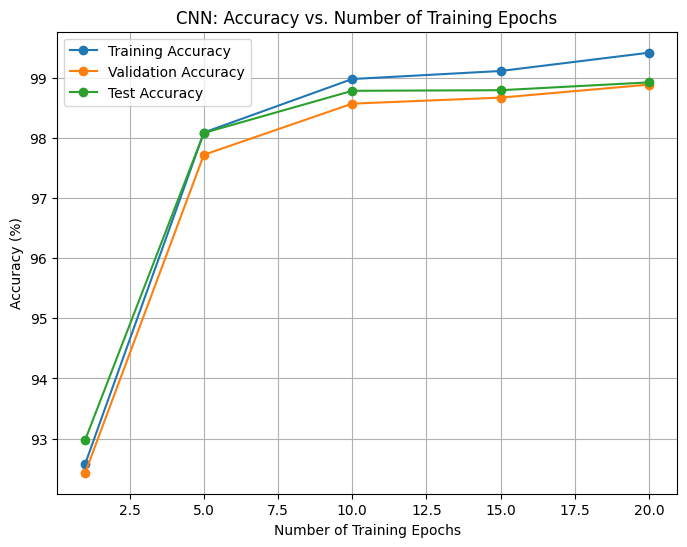

In [5]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta

# We know that MNIST images are 28 pixels in each dimension.
img_size = 28
img_shape = (img_size, img_size)

def create_cnn():
    class cnn(nn.Module):
        def __init__(self):
            super().__init__()
            # Convolutional Layer 1.
            filter_size1 = 5    # 5 x 5 pixels.
            num_filters1 = 16   # 16 filters.
            # Convolutional Layer 2.
            filter_size2 = 5    # 5 x 5 pixels.
            num_filters2 = 36   # 36 filters.
            # Fully-connected layer.
            fc_size = 128
            # Number of channels for gray-scale.
            num_channels = 1
            # Number of classes (10 digits).
            num_classes = 10

            self.layer_conv1 = nn.Conv2d(num_channels, num_filters1, (filter_size1, filter_size1), padding='same')
            self.layer_conv2 = nn.Conv2d(num_filters1, num_filters2, (filter_size2, filter_size2), padding='same')
            self.pool = nn.MaxPool2d(2)
            self.layer_fc1 = nn.Linear(1764, fc_size)
            self.layer_fc2 = nn.Linear(fc_size, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.layer_conv1(x)))
            x = self.pool(F.relu(self.layer_conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.layer_fc1(x))
            x = self.layer_fc2(x)
            return x
    return cnn()

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X.float())
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss_val, current = loss.item(), batch * len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    accuracy = 100 * correct / size
    return accuracy, test_loss

# Hyper-parameters for CNN training.
learning_rate = 1e-4
train_batch_size = 64
test_batch_size = 256

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load MNIST data.
transform = transforms.ToTensor()
full_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, transform=transform)

# Split the original training set into new train and validation sets.
# For example, 90% for training and 10% for validation.
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, validset = random_split(full_trainset, [train_size, val_size])

train_dataloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
valid_dataloader = DataLoader(validset, batch_size=train_batch_size, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=test_batch_size, shuffle=False)

# Grid over different numbers of training epochs.
epoch_options = [1, 5, 10, 15, 20]

train_accs = []
val_accs = []
test_accs = []

for epochs in epoch_options:
    print(f"\nTraining CNN for {epochs} epochs")
    # For a fair comparison, reinitialize the model for each setting.
    model = create_cnn().to(device)
    cost = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train for the specified number of epochs.
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train(train_dataloader, model, cost, optimizer)

    # Evaluate on train, validation, and test sets.
    train_accuracy, _ = evaluate(train_dataloader, model, cost)
    val_accuracy, _ = evaluate(valid_dataloader, model, cost)
    test_accuracy, _ = evaluate(test_dataloader, model, cost)

    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
    test_accs.append(test_accuracy)

    print(f"After {epochs} epochs: Train Acc = {train_accuracy:.2f}%, Val Acc = {val_accuracy:.2f}%, Test Acc = {test_accuracy:.2f}%")

# Plotting the results.
plt.figure(figsize=(8, 6))
plt.plot(epoch_options, train_accs, marker='o', label='Training Accuracy')
plt.plot(epoch_options, val_accs, marker='o', label='Validation Accuracy')
plt.plot(epoch_options, test_accs, marker='o', label='Test Accuracy')
plt.xlabel("Number of Training Epochs")
plt.ylabel("Accuracy (%)")
plt.title("CNN: Accuracy vs. Number of Training Epochs")
plt.legend()
plt.grid(True)
plt.show()
